# 1 - Implémentation naïve : pur Python

Import des **librairies nécessaires** :

In [1]:
import numpy as np
import pandas as pd
import time
import tkinter as tk
from matplotlib import pyplot as plt
from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg, NavigationToolbar2Tk)
from matplotlib.backend_bases import key_press_handler
from matplotlib.figure import Figure
import seaborn as sns

### Déclaration des fonctions

Fonction d'**échappement** : pour **un point complexe** donné ``c``, renvoie le **nombre d'itérations nécessaires** pour que la suite complexe dépasse la norme maximale ``max_norm``, ou à défaut, le nombre maximal d'itérations ``n_max``.

In [2]:
def escape_serial(c, n_max, max_norm):
    z = 0.0j
    i = 0
    
    while z.real * z.real + z.imag * z.imag < max_norm and i < n_max :
        z = z*z + c
        i += 1
        
    return i

Fonction d'**agrégation** : pour une **fenêtre carrée** définie sur le plan par un centre ``center``, une longueur de côté ``2*pad`` et une résolution ``n_dots`` (nombre points en hauteur et en largeur), renvoie sous forme d'**array numpy** la **valeur de la fonction d'échappement** pour chacun des points de la fenêtre.  
Les calculs sont effectués **en série** dans les boucles for imbriquées.

In [3]:
def mandelbrot_serial(center, pad, n_dots, max_norm=16, n_max=1000):
    step = 2.0*pad/n_dots
        
    counts = np.zeros((n_dots, n_dots), dtype=np.int32)
    
    for i in range(n_dots):
        imag = (center.imag + pad) - i*step
        for j in range(n_dots):
            real = (center.real-pad) + j*step
            c = real + imag*1j
            counts[i,j] = escape_serial(c, n_max, max_norm)
            
    return np.asarray(counts)

Fonction d'**affichage** : pour une fenêtre carrée définie sur le plan comme expliqué ci-dessus, affiche sous forme d'**image** le **résultat de la fonction d'agrégation sérielle** (grâce à une **échelle de couleur**) précédé du **temps de calcul** requis par son exécution (cette fonction renvoie également ce temps de calcul en sortie).

In [4]:
def display_serial(pad, n_dots, max_norm, n_max=1000, center = 0.0j):
    t0 = time.time()
    frame = mandelbrot_serial(center, pad, n_dots, max_norm, n_max)
    t1 = time.time()
    print('Serial computation time : {} seconds'.format(round(t1-t0, 3)))
    bounds = [center.real - pad, center.real + pad, center.imag - pad, center.imag + pad]
    plt.imshow(frame, interpolation='bilinear', extent = bounds)
    plt.colorbar()
    return t1 - t0

### Exemple de résultat : image et temps de calcul pour une fenêtre [-1,1;-1,1] avec 500 points par côté

Serial computation time : 31.247 seconds


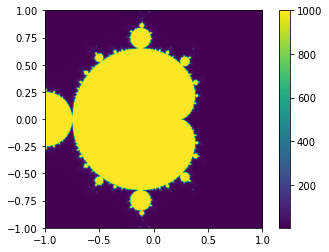

In [5]:
naive_time = display_serial(1, 500, 16, 1000, 0.0j)

### Interface graphique : Tkinter

Instanciation d'une interface graphique **interactive** : la vue prise sur l'ensemble de Mandelbrot change en fonction des actions réalisées par l'utilisateur sur son **clavier**.

Real part of center point : 0
Imaginary part of center point : 0
Number of points per row/column : 500
Margin on each side of center point : 1


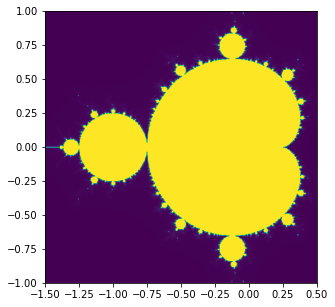

In [6]:
class MainWindow():
    def __init__(self,master): #initialisation de l'interface
        self.master = master
        self.build_frame(master)
        self.build_canvas()
        self.build_commands()
        self.iter = 0
        self.centerx = float(input('Real part of center point : '))
        self.centery = float(input('Imaginary part of center point : '))
        self.n_dots = int(input('Number of points per row/column : '))
        self.pad = int(input('Margin on each side of center point : '))
        self.display(pad = self.pad, n_dots = self.n_dots, center = complex(self.centerx, self.centery))
        
    def build_frame(self, master): #déclaration du premier cadre
        self.frame = tk.Frame(master = master)
        self.frame.pack(fill=tk.BOTH, expand=1)
        
    def build_commands(self): #association des actions (déplacement, zoom) aux touches du clavier
        self.master.bind('q', self.zoom_out)
        self.master.bind('d', self.zoom_in)
        self.master.bind('<Left>', self.left)
        self.master.bind('<Right>', self.right)
        self.master.bind('<Up>', self.up)
        self.master.bind('<Down>', self.down)
        
    def build_canvas(self): #création de la zone d'affichage de l'image
        fig = plt.figure(figsize=(5,5))
        self.canvas = FigureCanvasTkAgg(fig, master=self.frame)
        self.canvas.get_tk_widget().pack(side=tk.TOP, expand=1)

    #actions de zoom    
        
    def zoom_in(self, event):
        self.iter += 1
        self.pad = 0.75*self.pad
        self.display(pad = self.pad, n_dots = self.n_dots, center = complex(self.centerx, self.centery))
    
    def zoom_out(self, event):
        self.iter += 1
        self.pad = self.pad/0.75
        self.display(pad = self.pad, n_dots = self.n_dots, center = complex(self.centerx, self.centery))
    
    #actions de déplacement
    
    def left(self, event):
        self.iter += 1
        self.centerx -= self.pad/2
        self.display(pad = self.pad, n_dots = self.n_dots, center = complex(self.centerx, self.centery))
    
    def right(self, event):
        self.iter += 1
        self.centerx += self.pad/2
        self.display(pad = self.pad, n_dots = self.n_dots, center = complex(self.centerx, self.centery))
        
    def up(self, event):
        self.iter += 1
        self.centery += self.pad/2
        self.display(pad = self.pad, n_dots = self.n_dots, center = complex(self.centerx, self.centery))
        
    def down(self, event):
        self.iter += 1
        self.centery -= self.pad/2
        self.display(pad = self.pad, n_dots = self.n_dots, center = complex(self.centerx, self.centery))

    def display(self, pad, n_dots, max_norm=16, n_max=1000, center = 0.0j): #fonction d'affichage interne
        bounds = [center.real - pad, center.real + pad, center.imag - pad, center.imag + pad]
        
        frame = mandelbrot_serial(center, pad, n_dots, max_norm, n_max)
        
        if self.iter == 0: #premier affichage
            self.im = plt.imshow(frame, interpolation='bilinear', extent=bounds)
            self.canvas.draw()
            
        else: #affichages suivants
            self.im.set_data(frame)
            self.im.set_extent(bounds)
            self.canvas.draw()

if __name__ == "__main__": #création de l'interface graphique
    root = tk.Tk()
    app = MainWindow(root)
    root.mainloop()

### Evolution du temps de calcul en fonction de la résolution

Text(0, 0.5, 'Seconds')

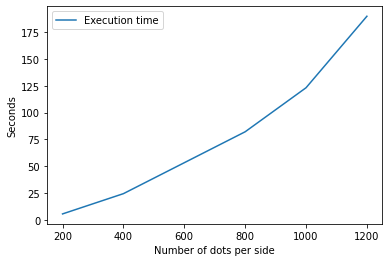

In [7]:
time_dots = np.zeros((6,))

i = 0
for num_dots in range(200,1400,200):
    t0 = time.time()
    mandelbrot_serial(0.0j, 1, num_dots, 16, 1000)
    t1 = time.time()
    time_dots[i] = t1 - t0
    i += 1
    
df = pd.DataFrame(time_dots.T, index = [i for i in range(200,1400,200)], columns=['Execution time'])

df.plot.line()
plt.xlabel('Number of dots per side')
plt.ylabel('Seconds')

### Evolution du temps de calcul en fonction du nombre maximum d'itérations

Text(0, 0.5, 'Seconds')

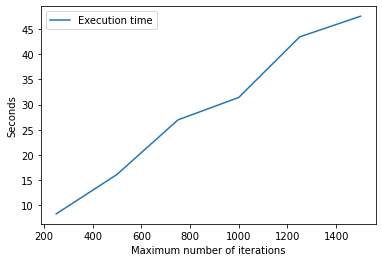

In [8]:
time_n_max = np.zeros((6,))

i = 0
for num_max in range(250,1750,250):
    t0 = time.time()
    mandelbrot_serial(0.0j, 1, 500, 16, num_max)
    t1 = time.time()
    time_n_max[i] = t1 - t0
    i += 1
    
df2 = pd.DataFrame(time_n_max.T, index = [i for i in range(250,1750,250)], columns=['Execution time'])

df2.plot.line()
plt.xlabel('Maximum number of iterations')
plt.ylabel('Seconds')

### Calcul du speed-up théorique (loi d'Amdahl)

Serial computation time : 32.496 seconds
Temps de calcul (portion parallélisable) : 32.49578881263733
Temps de calcul total : 32.565733671188354
Proportion de code non-parallélisable : 0.0021478053974539613
Valeur du speed-up théorique : 3.9743913424691515


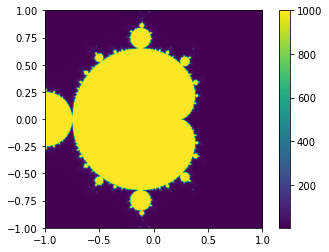

In [9]:
t0 = time.time()
par_time = display_serial(1, 500, 16, 1000, 0.0j)
t1 = time.time()
full_time = t1 - t0
alpha = 1 - par_time/full_time
th_sp = 1/(alpha+(1-alpha)/4)

print('Temps de calcul (portion parallélisable) : {}'.format(par_time))
print('Temps de calcul total : {}'.format(full_time))
print('Proportion de code non-parallélisable : {}'.format(alpha))
print('Valeur du speed-up théorique : {}'.format(th_sp))

# Implémentation parallèle : Cython

Chargement de Cython :

In [10]:
%load_ext Cython

### Import des librairies, déclaration des fonctions

On retrouve une fonction d'**échappement** et une fonction d'**agrégation** comme dans l'implémentation sérielle. Ici, la fonction d'agrégation **parallélise la première boucle** (qui parcourt les lignes) grâce à la fonction ``prange``, dont l'utilisateur peut spécifier les arguments ``num_threads`` et ``chunksize``.

In [11]:
%%cython

from cython cimport boundscheck, wraparound
from cython.parallel cimport prange
import numpy as np

cdef int escape_parallel(double complex c, int n_max, double max_norm) nogil:
    cdef :
        int i = 0
        double complex z = 0.0j
    while z.real * z.real + z.imag * z.imag < max_norm and i < n_max :
        z = z*z + c
        i += 1
        
    return i

@boundscheck(False)
@wraparound(False)
def mandelbrot_parallel(double complex center, double pad, int n_dots, double max_norm=16, int n_max=1000, int n_threads=4, int cs=1):
    cdef :
        double step = 2.0*pad/n_dots
        int i, j
        double complex c
        double real, imag
        int[:, ::1] counts
        
    counts = np.zeros((n_dots, n_dots), dtype=np.int32)
    
    for i in prange(n_dots, nogil=True, schedule='dynamic', num_threads = n_threads, chunksize=cs):
        imag = (center.imag + pad) - i*step
        for j in range(n_dots):
            real = (center.real-pad) + j*step
            c = real + imag*1j
            counts[i,j] = escape_parallel(c, n_max, max_norm)
            
    return np.asarray(counts)

Comme dans l'implémentation sérielle, la fonction d'**affichage** nous permet d'obtenir l'**image** correspondant à une fenêtre spécifique et le **temps de calcul** requis par la fonction d'**aggrégation parallèle**.

In [12]:
def display_parallel(pad, n_dots, max_norm, n_max=1000, center = 0.0j):
    t0 = time.time()
    frame = mandelbrot_parallel(center, pad, n_dots, max_norm, n_max)
    t1 = time.time()
    print('Parallel computation time : {} seconds'.format(round(t1-t0, 3)))
    bounds = [center.real - pad, center.real + pad, center.imag - pad, center.imag + pad]
    plt.imshow(frame, extent = bounds)

### Exemple de résultat : image et temps de calcul pour une fenêtre [-1,1;-1,1] avec 500 points par côté

Nous constatons que le **temps de calcul** est effectivement **beaucoup plus rapide** avec l'implémentation parallèle.

Parallel computation time : 0.474 seconds


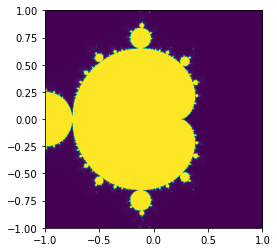

In [13]:
display_parallel(1, 500, 16, 1000, 0.0j)

### Interface graphique : Tkinter

Cette interface graphique est semblable à celle de l'implémentation sérielle ; seul l'**enchaînement des images** se trouve **accéléré** grâce à l'implémentation parallèle. A ce stade, nous utilisons des valeurs par défaut (4 pour ``num_threads`` et 1 pour ``chunksize``).

Real part of center point : 0
Imaginary part of center point : 0
Number of points per row/column : 500
Margin on each side of center point : 1


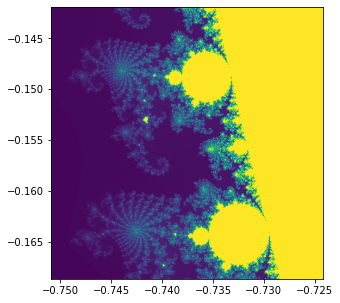

In [15]:
class MainWindow():
    def __init__(self,master): #initialisation de l'interface
        self.master = master
        self.build_frame(master)
        self.build_canvas()
        self.build_commands()
        self.iter = 0
        self.centerx = float(input('Real part of center point : '))
        self.centery = float(input('Imaginary part of center point : '))
        self.n_dots = int(input('Number of points per row/column : '))
        self.pad = int(input('Margin on each side of center point : '))
        self.display(pad = self.pad, n_dots = self.n_dots, center = complex(self.centerx, self.centery))
        
    def build_frame(self, master): #déclaration du premier cadre
        self.frame = tk.Frame(master = master)
        self.frame.pack(fill=tk.BOTH, expand=1)
        
    def build_commands(self): #association des actions (déplacement, zoom) aux touches du clavier
        self.master.bind('q', self.zoom_out)
        self.master.bind('d', self.zoom_in)
        self.master.bind('<Left>', self.left)
        self.master.bind('<Right>', self.right)
        self.master.bind('<Up>', self.up)
        self.master.bind('<Down>', self.down)
        
    def build_canvas(self): #création de la zone d'affichage de l'image
        fig = plt.figure(figsize=(5,5))
        self.canvas = FigureCanvasTkAgg(fig, master=self.frame)
        self.canvas.get_tk_widget().pack(side=tk.TOP, expand=1)

    #actions de zoom    
        
    def zoom_in(self, event):
        self.iter += 1
        self.pad = 0.75*self.pad
        self.display(pad = self.pad, n_dots = self.n_dots, center = complex(self.centerx, self.centery))
    
    def zoom_out(self, event):
        self.iter += 1
        self.pad = self.pad/0.75
        self.display(pad = self.pad, n_dots = self.n_dots, center = complex(self.centerx, self.centery))
    
    #actions de déplacement
    
    def left(self, event):
        self.iter += 1
        self.centerx -= self.pad/2
        self.display(pad = self.pad, n_dots = self.n_dots, center = complex(self.centerx, self.centery))
    
    def right(self, event):
        self.iter += 1
        self.centerx += self.pad/2
        self.display(pad = self.pad, n_dots = self.n_dots, center = complex(self.centerx, self.centery))
        
    def up(self, event):
        self.iter += 1
        self.centery += self.pad/2
        self.display(pad = self.pad, n_dots = self.n_dots, center = complex(self.centerx, self.centery))
        
    def down(self, event):
        self.iter += 1
        self.centery -= self.pad/2
        self.display(pad = self.pad, n_dots = self.n_dots, center = complex(self.centerx, self.centery))

    def display(self, pad, n_dots, max_norm=16, n_max=1000, center = 0.0j): #fonction d'affichage interne
        bounds = [center.real - pad, center.real + pad, center.imag - pad, center.imag + pad]
        
        frame = mandelbrot_parallel(center, pad, n_dots, max_norm, n_max)
        
        if self.iter == 0: #premier affichage
            self.im = plt.imshow(frame, interpolation='bilinear', extent=bounds)
            self.canvas.draw()
            
        else: #affichages suivants
            self.im.set_data(frame)
            self.im.set_extent(bounds)
            self.canvas.draw()

if __name__ == "__main__": #création de l'interface graphique
    root = tk.Tk()
    app = MainWindow(root)
    root.mainloop()

# Analyse comparative

### Temps de calcul en fonction du nombre de threads et de chunksize

Text(919.4727272727271, 0.5, 'Execution time')

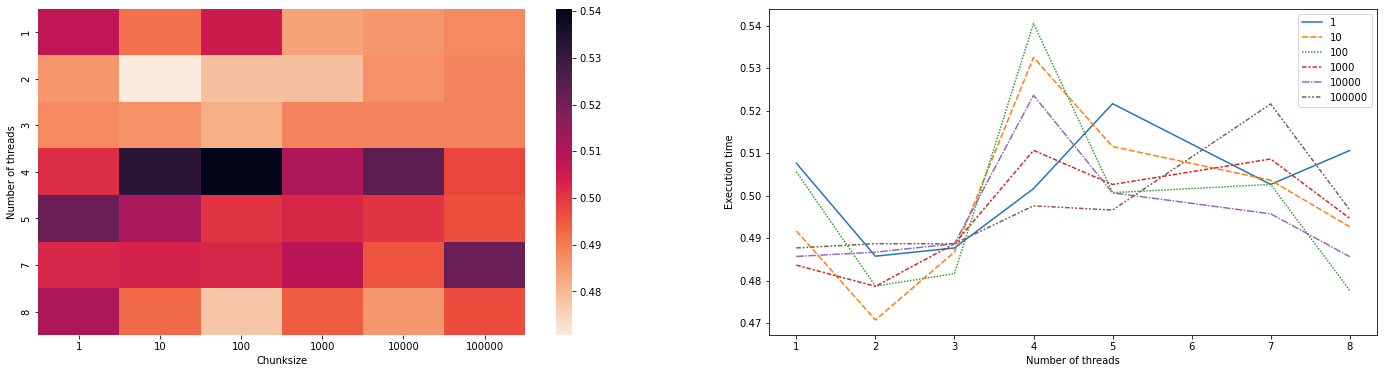

In [23]:
def store_results_th_cs(list_n_threads, list_chunksize):
    res = np.zeros((len(list_n_threads), len(list_chunksize)))
    for i in range(len(list_n_threads)):
        for j in range(len(list_chunksize)):
            t0 = time.time()
            mandelbrot_parallel(0.0j, 1, 500, 16, 1000, list_n_threads[i], list_chunksize[j])
            t1 = time.time()
            res[i,j] = t1-t0
    df = pd.DataFrame(res, index = list_n_threads, columns = list_chunksize)
    return df

df_th_cs = store_results_th_cs([1,2,3,4,5,7,8], [1,10,100,1000,10000,100000])

fig, axes = plt.subplots(1,2, figsize=(24,6))

sns.heatmap(ax = axes[0], data = df_th_cs, cmap = sns.cm.rocket_r)
axes[0].set_xlabel('Chunksize')
axes[0].set_ylabel('Number of threads')
sns.lineplot(ax = axes[1], data = df_th_cs)
axes[1].set_xlabel('Number of threads')
axes[1].set_ylabel('Execution time')

### Evolution du speed-up en fonction de chunksize

Text(0, 0.5, 'Speedup')

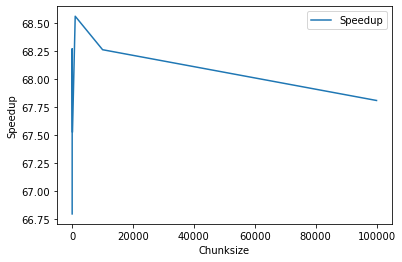

In [25]:
def speedup_ch(list_chunksize):
    res = np.zeros((len(list_chunksize),))
    for i in range(len(list_chunksize)):
        t0 = time.time()
        mandelbrot_parallel(0.0j, 1, 500, 16, 1000, 2, list_chunksize[i])
        t1 = time.time()
        res[i] = naive_time/(t1-t0)
    df = pd.DataFrame(res.T, index = list_chunksize, columns=['Speedup'])
    return df

speedup_ch_df = speedup_ch([1,10,100,1000,10000,100000])

speedup_ch_df.plot.line()
plt.xlabel('Chunksize')
plt.ylabel('Speedup')

### Evolution du speed-up en fonction du nombre de threads

Text(0, 0.5, 'Speedup')

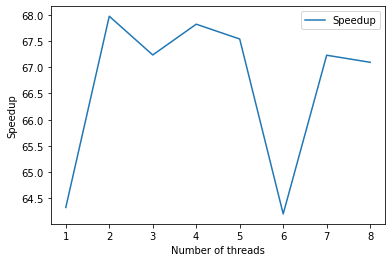

In [27]:
def speedup_th(list_n_threads):
    res = np.zeros((len(list_n_threads),))
    for i in range(len(list_n_threads)):
        t0 = time.time()
        mandelbrot_parallel(0.0j, 1, 500, 16, 1000, list_n_threads[i], 10)
        t1 = time.time()
        res[i] = naive_time/(t1-t0)
    df = pd.DataFrame(res.T, index = list_n_threads, columns=['Speedup'])
    return df

speedup_th_df = speedup_ch([1,2,3,4,5,6,7,8])

speedup_th_df.plot.line()
plt.xlabel('Number of threads')
plt.ylabel('Speedup')

### Evolution du speed-up en fonction de la résolution

Text(0, 0.5, 'Speedup')

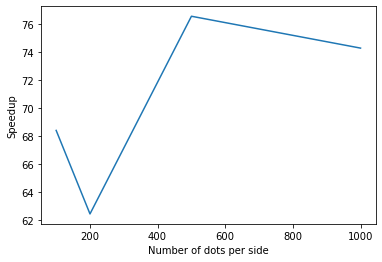

In [34]:
def speedup_d(list_n_dots):
    res = np.zeros((3, len(list_n_dots)))
    for i in range(len(list_n_dots)):
        t0 = time.time()
        mandelbrot_parallel(0.0j, 1, list_n_dots[i], 16, 1000, 2, 10)
        t1 = time.time()
        mandelbrot_serial(0.0j, 1, list_n_dots[i], 16, 1000)
        t2 = time.time()
        res[0,i] = t1-t0
        res[1,i] = t2-t1
        res[2,i] = res[1,i]/res[0,i]
    df = pd.DataFrame(res.T, index = list_n_dots, columns=['Parallel time', 'Serial time', 'Speedup'])
    return df

speedup_d_df = speedup_d([100,200,500,1000])

speedup_d_df['Speedup'].plot.line()
plt.xlabel('Number of dots per side')
plt.ylabel('Speedup')

### Interface graphique avec les paramètres optimaux

Version définitive de l'interface graphique : les calculs sont parallélisés avec les paramètres permettant d'obtenir le **meilleur speed-up** afin de s'approcher au mieux d'une **fluidité vidéo**.

Real part of center point : 0
Imaginary part of center point : 0
Number of points per row/column : 500
Margin on each side of center point : 1


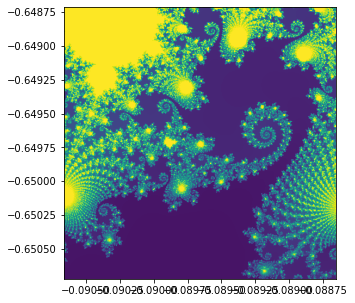

In [36]:
class MainWindow():
    def __init__(self,master): #initialisation de l'interface
        self.master = master
        self.build_frame(master)
        self.build_canvas()
        self.build_commands()
        self.iter = 0
        self.centerx = float(input('Real part of center point : '))
        self.centery = float(input('Imaginary part of center point : '))
        self.n_dots = int(input('Number of points per row/column : '))
        self.pad = int(input('Margin on each side of center point : '))
        self.display(pad = self.pad, n_dots = self.n_dots, center = complex(self.centerx, self.centery))
        
    def build_frame(self, master): #déclaration du premier cadre
        self.frame = tk.Frame(master = master)
        self.frame.pack(fill=tk.BOTH, expand=1)
        
    def build_commands(self): #association des actions (déplacement, zoom) aux touches du clavier
        self.master.bind('q', self.zoom_out)
        self.master.bind('d', self.zoom_in)
        self.master.bind('<Left>', self.left)
        self.master.bind('<Right>', self.right)
        self.master.bind('<Up>', self.up)
        self.master.bind('<Down>', self.down)
        
    def build_canvas(self): #création de la zone d'affichage de l'image
        fig = plt.figure(figsize=(5,5))
        self.canvas = FigureCanvasTkAgg(fig, master=self.frame)
        self.canvas.get_tk_widget().pack(side=tk.TOP, expand=1)

    #actions de zoom    
        
    def zoom_in(self, event):
        self.iter += 1
        self.pad = 0.75*self.pad
        self.display(pad = self.pad, n_dots = self.n_dots, center = complex(self.centerx, self.centery))
    
    def zoom_out(self, event):
        self.iter += 1
        self.pad = self.pad/0.75
        self.display(pad = self.pad, n_dots = self.n_dots, center = complex(self.centerx, self.centery))
    
    #actions de déplacement
    
    def left(self, event):
        self.iter += 1
        self.centerx -= self.pad/2
        self.display(pad = self.pad, n_dots = self.n_dots, center = complex(self.centerx, self.centery))
    
    def right(self, event):
        self.iter += 1
        self.centerx += self.pad/2
        self.display(pad = self.pad, n_dots = self.n_dots, center = complex(self.centerx, self.centery))
        
    def up(self, event):
        self.iter += 1
        self.centery += self.pad/2
        self.display(pad = self.pad, n_dots = self.n_dots, center = complex(self.centerx, self.centery))
        
    def down(self, event):
        self.iter += 1
        self.centery -= self.pad/2
        self.display(pad = self.pad, n_dots = self.n_dots, center = complex(self.centerx, self.centery))

    def display(self, pad, n_dots, max_norm=16, n_max=1000, center = 0.0j): #fonction d'affichage interne
        bounds = [center.real - pad, center.real + pad, center.imag - pad, center.imag + pad]
        
        frame = mandelbrot_parallel(center, pad, n_dots, max_norm, n_max, 2, 10)
        
        if self.iter == 0: #premier affichage
            self.im = plt.imshow(frame, interpolation='bilinear', extent=bounds)
            self.canvas.draw()
            
        else: #affichages suivants
            self.im.set_data(frame)
            self.im.set_extent(bounds)
            self.canvas.draw()

if __name__ == "__main__": #création de l'interface graphique
    root = tk.Tk()
    app = MainWindow(root)
    root.mainloop()